# Critical Points for One-Deep Neural Networks

***Note: I'm running in this in Google Colab.***
In this notebook, we will walk through a tutorial for building a critical point search algorithm for one-deep neural networks. We assume that the attacker knows the model architecture and has query access to the victim model. In this tutorial, we also have access to the gradients of the model outputs with respect to our queries. 
This notebook is based off of the following papers: 

- High Accuracy and High Fidelity Extraction of Neural Networks (Matthew Jagielski, Nicholas Carlini, David Berthelot, Alex Kurakin, Nicolas Papernot @ USENIX 2020). 
    - [paper](https://arxiv.org/abs/1909.01838)
    - [talk](https://youtu.be/PPU2a_A2ScI)


- Cryptanalytic Extraction of Neural Network Models (Nicholas Carlini, Matthew Jagielski, Ilya Mironov @ CRYPTO 2020)
    - [paper](https://arxiv.org/abs/2003.04884)
    - [talk](https://youtu.be/I-KpbLQlL_o)

It may be helpful to go through the previous tutorial. 
## 1. Imports
Let's import some libraries. We will be using `jax` as our main library.

In [22]:
import jax                                                           # jax
import jax.numpy as jnp                                              # numpy from jax
from sklearn.datasets import make_regression                         # building a simple dataset
from sklearn.model_selection import train_test_split                 # splitting train and test

from tqdm import tqdm                                                # progress bar
import matplotlib.pyplot as plt                                      # plotting library
from jax.config import config; config.update("jax_enable_x64", True) # enable double-precision
import numpy as np                                                   # classic numpy

## 2. Creating the dataset and model

We will be creating a one-hidden layer neural network which will assume the following functional form:
$$f(x) = A^{1} \texttt{relu}(A^0x + B^0) + B^1. $$

where $x \in \mathrm{R}^{1xd}, A^0 \in \mathrm{R}^{dxh}, B^0 \in \mathrm{R}^h, A^1 \in \mathrm{R}^{hxK},\text{and } B^1\in \mathrm{R}^K.$

Again, as in the previous notebook, we will build a simple regression dataset. 

In [29]:
d = 2       # input size
h = 3      # hidden size
K = 1       # output
seed = 5   # initialization for random state in jnp.

X, y = make_regression(n_samples=1000, n_features=d)            # create dataset
x_train, x_test, y_train, y_test = train_test_split(X, y)       # split dataset
train_mean = jnp.mean(x_train, axis=0, keepdims=True)           # train mean
train_std  = jnp.std(x_train, axis=0, keepdims=True)            # train std
x_train = (x_train - train_mean) / train_std                    # norm. train
x_test  = (x_test - train_mean) / train_std                     # norm. test
print("Dataset size:", x_train.shape, x_test.shape, y_train.shape, y_test.shape)

# model weights
key = jax.random.PRNGKey(seed)
key, subkey = jax.random.split(key)
params = {}
params['A0'] = jax.random.normal(key, shape=(d, h))
params['B0'] = jnp.zeros(shape=(h,))
key, subkey  = jax.random.split(key)
params['A1'] = jax.random.normal(key, shape=(h,K))
params['B1'] = jnp.zeros(shape=(K,))

# printing the sizes of each distinct parameter in the model.
for key, value in params.items():
  print(key, value.shape)

Dataset size: (750, 2) (250, 2) (750,) (250,)
A0 (2, 3)
B0 (3,)
A1 (3, 1)
B1 (1,)


## 3. Creating the forward pass, loss function, and update rule.
This time, the forward pass will involve two linear transformations with one non-linearity (ReLU) in between.

In [30]:
from jax._src.tree_util import tree_structure
def forward(params, X):
  fst_layer  = jnp.dot(X, params['A0']) + params['B0']
  rlu_layer = jnp.maximum(fst_layer, 0)
  snd_layer  = jnp.dot(rlu_layer, params['A1']) + params['B1']
  return snd_layer

def loss_fn(params, X, y):
  err = forward(params, X) - y
  return jnp.mean(jnp.square(err))  

# autodiff allows us to differeniate a function w.r.t its inputs (by default, the first argument)
value_grad_fn = jax.value_and_grad(loss_fn) 

def update(params, grads, learning_rate):
    return jax.tree_multimap(lambda p, g: p - learning_rate * g, params, grads)

NUM_EPOCHS=100
learning_rate = 3e-2
train_losses = []
test_losses  = []
for epoch in tqdm(range(NUM_EPOCHS)):
    loss = loss_fn(params, x_test, y_test)
    test_losses.append(loss)

    loss, grads = value_grad_fn(params, x_train, y_train) 
    train_losses.append(loss)
    params = update(params, grads, learning_rate)

100%|██████████| 100/100 [00:02<00:00, 41.11it/s]


In [31]:
for key, value in params.items():
  print(key, value)

A0 [[-0.39562756  0.84374838 -0.31216698]
 [-0.36080508  0.69329667 -0.45145564]]
A1 [[ 1.49670122]
 [ 0.75832802]
 [-0.81076836]]
B0 [ 1.164361    0.90859791 -0.26216067]
B1 [0.82986245]


## 4. Simple Critical Point Search
Here's a rather clunky implementation of critical point search. The idea here is to get a flavor of how to model this process of searching along the input space for points in which a particular ReLU has an input of exactly zero.


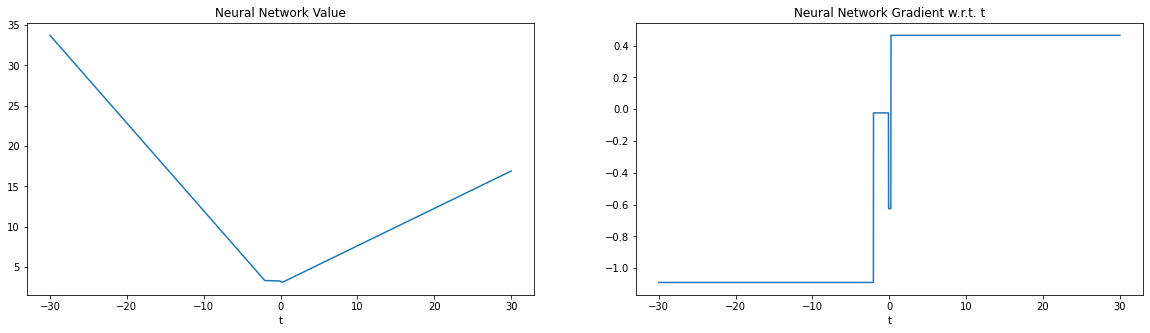

In [32]:
def critical_point_search(params, d, h, seed):
  key = jax.random.PRNGKey(seed)
  key, subkey = jax.random.split(key)
  u = jax.random.normal(key, shape=(1,d))
  v = jax.random.normal(subkey, shape=(1,d))

  ts = jnp.linspace(-30, 30, 10000)
  def L(ts, u, v):
    input_values = u + ts[...,None]*v
    return forward(params, input_values).squeeze((0,1))
  
  value_grad = jax.value_and_grad(L)
  # cool use of vmap. But there's an easier way.
  values, grads = jax.vmap(value_grad, in_axes=(0, None, None))(ts, u, v) # helpful link: https://jax.readthedocs.io/en/latest/jax.html#jax.vmap
  return values, grads, ts, u, v

values, grads, ts, u, v = critical_point_search(params, d, h, 2)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
ax[0].plot(ts, values)
ax[0].set_xlabel("t")
ax[0].set_title("Neural Network Value")
ax[1].plot(ts, grads)
ax[1].set_xlabel("t")
ax[1].set_title("Neural Network Gradient w.r.t. t");

As we can see from the output, we have three sharp changes along the $u + tv$ direction meaning that we've found three critical points (one for each hidden ReLU).

## 5. Recursive Implementation of Finding All Critical Points
 The following is a recursive approach to Algorithm 1 from the [first paper](https://arxiv.org/abs/1909.01838) mentioned above. 

In [33]:
def recursive_find_critical_points(params, u, v, t1, t2):
  """
  Recursively finds all critical points within the region t1 and t2.
  """

  # first Eq. in Section 6.3 of https://arxiv.org/abs/1909.01838.
  def L(t, u, v):
    input_values = u + t*v
    return forward(params, input_values).squeeze((0,1))
  gradL = jax.grad(L)

  # obtain gradient of L at points t1 and t2
  # normally we wouldn't be able to do this
  # we'd use a finite difference approach
  g1 = gradL(t1, u, v) 
  g2 = gradL(t2, u, v)

  # if the gradients are equal, then we have no critical points in this region.
  if jnp.isclose(g1,g2):
    return jnp.zeros_like(u)
  # split input space in half
  midpoint = t1/2. + t2/2.
  # if the midpoint and (t1 OR t2) are essentially the same, we've found a critical point.
  if jnp.isclose(midpoint, t1, rtol=1e-8):
    return u + t1*v
  # recurse on each half of the input space.
  else:
    return jnp.vstack([recursive_find_critical_points(params, u, v, t1, midpoint), recursive_find_critical_points(params, u, v, midpoint, t2)])

# kick off the recursive process
def start_critical_point_search(params, d, h, seed):
  key = jax.random.PRNGKey(seed)
  key, subkey = jax.random.split(key)

  u = jax.random.normal(key=key, shape=(1,d), dtype=jnp.float64)*5
  v = jax.random.normal(key=subkey, shape=(1,d), dtype=jnp.float64)*5

  # heuristics for sweeping a large portion of the input space.
  t1 = jnp.array([-h**2*2], dtype=jnp.float64)
  t2 = jnp.array([+h**2*2], dtype=jnp.float64)
  all_points = recursive_find_critical_points(params, u, v, t1, t2)
  only_critical_points = all_points[~jnp.all(all_points == 0, axis=1)]
  assert len(only_critical_points) == h
  return only_critical_points, len(all_points)

critical_points, num_queries = start_critical_point_search(params, d, h, seed=0)

In [35]:
critical_points, len(critical_points)

(DeviceArray([[-13.30023153,   8.61597922],
              [ -7.5627155 ,   7.8933468 ],
              [ -3.82634371,   7.4227558 ]], dtype=float64), 3)

It looks like we successfully found three critical points! Let's see how many queries that took.

In [36]:
print("Number of Queries:", num_queries)

Number of Queries: 81


## 6. Observing the Intermediate Activations
Now, let's act as a third party who *does* have access to the victim model. Let's forward propagate only through to the first layer in the network and observe what our inputs to the ReLU look like.

In [37]:
def fst_layer_forward(params, X):
  fst_layer  = jnp.dot(X, params['A0']) + params['B0']
  return fst_layer

for i in range(len(critical_points)):
  print(fst_layer_forward(params, critical_points[i:i+1]))
  print(forward(params, critical_points[i:i+1]))

print("-----------------------")

print("Index of ReLU which is at zero.")
for eval in fst_layer_forward(params, critical_points):
  print(jnp.argwhere(jnp.isclose(0, eval, atol=1e-05)==True))

[[ 3.31761012e+00 -4.34002120e+00  2.55970296e-08]]
[[5.79533353]]
[[ 1.30842008e+00 -5.98659999e-09 -1.46482654e+00]]
[[2.78817637]]
[[ 2.87880704e-08  2.82629846e+00 -2.41874748e+00]]
[[2.97312381]]
-----------------------
Index of ReLU which is at zero.
[[2]]
[[1]]
[[0]]


We can see that for each critical point, one of the ReLUs is sitting at zero! The next step in this process would be to use this critical points to extract the magnitude of the weights for the first layer's linear transformation.